1. Definición y construcción de un modelo híbrido de recomendación

- a) Objetivo de recomendación: Aumentar la satisfacción del usuario al proporcionar recomendaciones personalizadas de negocios y mejorar la visibilidad y el tráfico hacia negocios menos conocidos pero de alta calidad.

Objetivos estratégicos del proveedor del servicio:

- Aumentar la retención y la participación de los usuarios en la plataforma.
Promover negocios de alta calidad que aún no han sido descubiertos por una amplia audiencia.

Objetivos estratégicos del usuario del servicio:

- Descubrir nuevos negocios que se ajusten a sus intereses y preferencias.
Tomar decisiones informadas sobre qué negocios visitar en función de recomendaciones confiables.

Propósito de recomendación:

- Proveedor: Impulsar el crecimiento de la plataforma al aumentar la satisfacción del usuario y la visibilidad de negocios de alta calidad.
Usuario: Recibir recomendaciones de negocios personalizadas y de alta calidad basadas en sus intereses y contexto.

Tareas operativas:

- Predecir la valoración que un usuario daría a un negocio no visitado previamente.
- Identificar y recomendar negocios similares a los que un usuario ha valorado positivamente en el pasado.
- Incorporar información contextual, como la ubicación del usuario, para mejorar la calidad de las recomendaciones.

## Métricas:

- Precisión (RMSE, MAE, MRR): Para medir la diferencia entre las valoraciones reales y las predichas por el sistema de recomendación. Y medir resultados rankeados

- Recall@k y Precision@k: Para evaluar la calidad de las recomendaciones proporcionadas en términos de relevancia y exhaustividad.

- Diversidad: Para evaluar la variedad de las recomendaciones y evitar la sobreexposición a negocios populares.

In [ ]:
%pip install surprise sns joblib tensorflow scikit-learn contractions inflect pyinflect --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection.search import GridSearchCV
from pathlib import Path
from IPython.display import display,Markdown
import joblib
from tqdm import tqdm
# from google.colab import output, 
# output.enable_custom_widget_manager()
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from os import environ
import json
import contractions
import inflect
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import string
import unicodedata as ud
from time import perf_counter_ns

In [ ]:
nltk.download('all', quiet=True)

True

## 1. Datasets

  Documentación en [https://www.yelp.com/dataset/documentation/main](https://www.yelp.com/dataset/documentation/main)

In [ ]:
yelp_path = Path("./data/")

yelp_processed_data = Path("./processed_data/")

# ordenados por tamaño
yelp_business = Path(yelp_path,"yelp_academic_dataset_business.json")
yelp_tip = Path(yelp_path , "yelp_academic_dataset_tip.json")
yelp_checkin = Path(yelp_path , "yelp_academic_dataset_checkin.json")
yelp_user = Path(yelp_path , "yelp_academic_dataset_user.json")
yelp_review = Path(yelp_path , "yelp_academic_dataset_review.json")


los archivos son gigantes, por lo que se cargan por chunks (1 millón de lineas cada uno, en total son alrededor de 7 chunks para el archivo más grande), y se guarda con joblib para luego re-cargarlo completo con joblib, parece redundante pero ahorra mucha ram y tiempo en los archivos pesados

In [ ]:
def reload_dframe(json_path:Path):
  # carga el dataframe de path en chunks, lo guarda con joblib y lo recarga en la misma variable para ahorrar ram
  chunksize = 1e6
  yelp_data = []
  if Path(json_path.parent,f"{json_path.stem}.joblib").exists():
      yelp_data:pd.DataFrame = joblib.load(Path(json_path.parent,f"{json_path.stem}.joblib"))
  else:
    yelp_chunks = pd.read_json(json_path, lines=True, chunksize=chunksize)
    for chunk in tqdm(yelp_chunks):
        yelp_data.append(chunk)

    joblib.dump(pd.concat(yelp_data), Path(json_path.parent,f"{json_path.stem}.joblib"))
    yelp_data:pd.DataFrame = joblib.load(Path(json_path.parent,f"{json_path.stem}.joblib"))
  return yelp_data

### Business

In [ ]:
%%time
yelp_business_data = reload_dframe(yelp_business)

CPU times: total: 375 ms
Wall time: 950 ms


In [ ]:
yelp_business_data.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


 - Eliminar Address, city, state y postal code porque ya existe la latitud y longitud que codifica los mismos datos de forma numérica.
 - Eliminar is_open porque ya están las horas de apertura.

In [ ]:
yelp_business_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [ ]:
yelp_business_data.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


<AxesSubplot: >

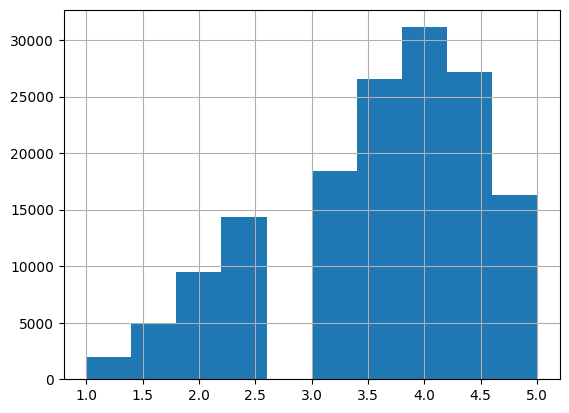

In [ ]:
yelp_business_data["stars"].hist()

In [ ]:
trans_yelp_business=yelp_business_data.drop(["address","city","state","postal_code","is_open"],axis=1)
trans_yelp_business.head(3)

,business_id,name,latitude,longitude,stars,review_count,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",34.426679,-119.711197,5.0,7,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,32.223236,-110.880452,3.5,22,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


de la columna attributes, se preservan los booleanos y pasar múltiples atributos a listas para aplicar OneHotEncoding, el resto se descartan debido a que tienen estructura muy compleja y los booleanos son suficientes (24)

In [ ]:
distinctBoolValues = []
rest =[]
for item in trans_yelp_business["attributes"]:
  if item:
    for it,val in item.items():
      if val in ["True","False"]:
        distinctBoolValues.append(it)
      rest.append(it)
distinctBoolValues = set(distinctBoolValues)
rest = set(rest)
print(len(distinctBoolValues),distinctBoolValues)
print(len(rest),rest)


24 {'GoodForKids', 'Open24Hours', 'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'BusinessAcceptsBitcoin', 'BikeParking', 'RestaurantsCounterService', 'RestaurantsTakeOut', 'HappyHour', 'DogsAllowed', 'BYOB', 'HasTV', 'WheelchairAccessible', 'RestaurantsTableService', 'CoatCheck', 'DriveThru', 'Caters', 'AcceptsInsurance', 'RestaurantsDelivery', 'OutdoorSeating', 'Corkage', 'RestaurantsGoodForGroups', 'GoodForDancing', 'ByAppointmentOnly'}
39 {'BusinessParking', 'GoodForKids', 'NoiseLevel', 'Music', 'Open24Hours', 'BestNights', 'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'GoodForMeal', 'BusinessAcceptsBitcoin', 'BikeParking', 'RestaurantsCounterService', 'BYOBCorkage', 'RestaurantsTakeOut', 'HappyHour', 'DogsAllowed', 'RestaurantsAttire', 'Smoking', 'BYOB', 'AgesAllowed', 'HasTV', 'HairSpecializesIn', 'WheelchairAccessible', 'RestaurantsPriceRange2', 'DietaryRestrictions', 'Alcohol', 'RestaurantsTableService', 'Ambience', 'CoatCheck', 'DriveThru', 'Caters', 'WiFi

Parsear las horas para que sean legibles, se crean columnas de la forma "(open|closing)\__nombre-día_" y su valor corresponde a la hora numérica en formato 24 horas (ejemplo, 6:00am equivale a 600 y 6:00pm a 1800), si hay un vacío, se llenan sus horarios vacíos con apertura y cierre a las 00:00 horas, que equivale a mantener cerrado ese día

In [ ]:
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [ ]:
businessmap={}

hoursmap_open={day:{} for day in days}
hoursmap_closing={day:{} for day in days}
for row in trans_yelp_business.itertuples(name="Business"):
  bid = row[1]
  attributes = row[7]
  hours=row[9]
  attribs=[]
  if attributes:
    for it,val in attributes.items():
      if val=="True":
        attribs.append(it)
  businessmap[bid]=attribs
    
  for day in days:
    mil_open_hour = 0
    mil_close_hour = 0
    if hours is not None and day in hours:
      hour=hours[day]
      hour_split = hour.split("-")
      open_hr,open_min = hour_split[0].split(":")
      close_hr,close_min = hour_split[1].split(":")
      mil_open_hour = int(open_hr+open_min.zfill(2))
      mil_close_hour = int(close_hr+close_min.zfill(2))
    hoursmap_open[day][bid] = mil_open_hour
    hoursmap_closing[day][bid] = mil_close_hour
    
trans_yelp_business["attributes"] = yelp_business_data["business_id"].map(businessmap)
trans_yelp_business.head(3)

,business_id,name,latitude,longitude,stars,review_count,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",34.426679,-119.711197,5.0,7,[ByAppointmentOnly],"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,38.551126,-90.335695,3.0,15,[BusinessAcceptsCreditCards],"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,32.223236,-110.880452,3.5,22,"[BikeParking, BusinessAcceptsCreditCards, Whee...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [ ]:
for day,daymap in hoursmap_open.items():
  trans_yelp_business[f"open_{day}"] = trans_yelp_business["business_id"].map(daymap)

for day,daymap in hoursmap_closing.items():
  trans_yelp_business[f"closing_{day}"] = trans_yelp_business["business_id"].map(daymap)

trans_yelp_business.head(3)

,business_id,name,latitude,longitude,stars,review_count,attributes,categories,hours,open_Monday,...,open_Friday,open_Saturday,open_Sunday,closing_Monday,closing_Tuesday,closing_Wednesday,closing_Thursday,closing_Friday,closing_Saturday,closing_Sunday
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",34.426679,-119.711197,5.0,7,[ByAppointmentOnly],"Doctors, Traditional Chinese Medicine, Naturop...",None,0,...,0,0,0,0,0,0,0,0,0,0
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,38.551126,-90.335695,3.0,15,[BusinessAcceptsCreditCards],"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",0,...,800,800,0,0,1830,1830,1830,1830,1400,0
2,tUFrWirKiKi_TAnsVWINQQ,Target,32.223236,-110.880452,3.5,22,"[BikeParking, BusinessAcceptsCreditCards, Whee...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",800,...,800,800,800,2200,2200,2200,2200,2300,2300,2200


In [ ]:
trans_yelp_business= trans_yelp_business.drop(["hours"],axis=1)

Transformar las categorías a listas, de modo que se pueda hacer OneHotEncoding más adelante

In [ ]:
trans_yelp_business["categories"]=trans_yelp_business["categories"].str.split(", ")
trans_yelp_business.head(3)


,business_id,name,latitude,longitude,stars,review_count,attributes,categories,open_Monday,open_Tuesday,...,open_Friday,open_Saturday,open_Sunday,closing_Monday,closing_Tuesday,closing_Wednesday,closing_Thursday,closing_Friday,closing_Saturday,closing_Sunday
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",34.426679,-119.711197,5.0,7,[ByAppointmentOnly],"[Doctors, Traditional Chinese Medicine, Naturo...",0,0,...,0,0,0,0,0,0,0,0,0,0
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,38.551126,-90.335695,3.0,15,[BusinessAcceptsCreditCards],"[Shipping Centers, Local Services, Notaries, M...",0,800,...,800,800,0,0,1830,1830,1830,1830,1400,0
2,tUFrWirKiKi_TAnsVWINQQ,Target,32.223236,-110.880452,3.5,22,"[BikeParking, BusinessAcceptsCreditCards, Whee...","[Department Stores, Shopping, Fashion, Home & ...",800,800,...,800,800,800,2200,2200,2200,2200,2300,2300,2200


In [ ]:
trans_yelp_business["review_count"].describe()

count    150346.000000
mean         44.866561
std         121.120136
min           5.000000
25%           8.000000
50%          15.000000
75%          37.000000
max        7568.000000
Name: review_count, dtype: float64

<AxesSubplot: ylabel='Frequency'>

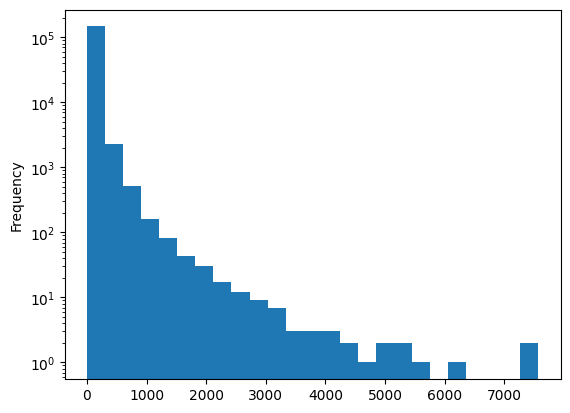

In [ ]:
trans_yelp_business["review_count"].plot(kind="hist",logy=True,xlabel="review count",bins=25)


La distribución de reviews muestra que muy pocos lugares tienen más de 10 reseñas

In [ ]:
trans_yelp_business["stars"].describe()

count    150346.000000
mean          3.596724
std           0.974421
min           1.000000
25%           3.000000
50%           3.500000
75%           4.500000
max           5.000000
Name: stars, dtype: float64

<AxesSubplot: ylabel='Frequency'>

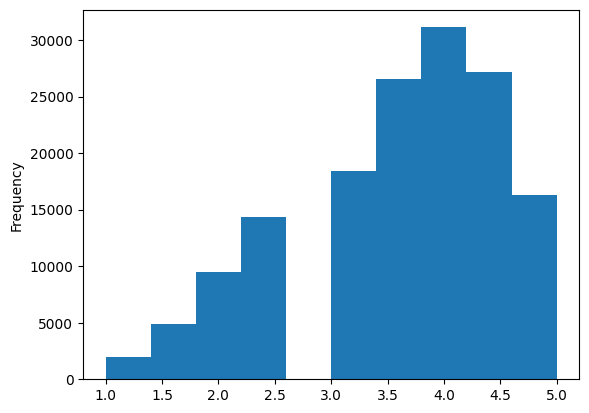

In [ ]:
trans_yelp_business["stars"].plot(kind="hist")

OneHot Encoding de attributes y categories

In [ ]:
trans_yelp_business['categories'] = trans_yelp_business['categories'].fillna("").apply(list)

In [ ]:
cats=[]
for l in trans_yelp_business['categories']:
  cats +=  l
cats = pd.Series(cats)

In [ ]:
len(set(cats))

1311

Hay demasiadas categorías, por lo que se tomarán las más recurrentes y se agrupará el resto en "otros"

<AxesSubplot: >

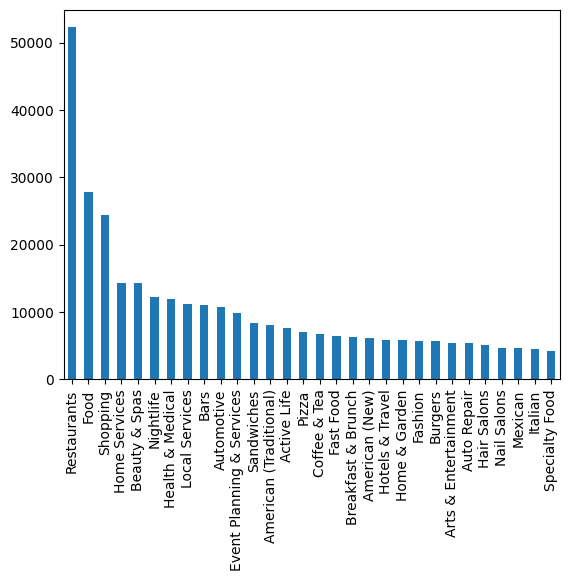

In [ ]:
cats.value_counts().nlargest(30).plot(kind="bar")

A manera de método de codo, se mantendrá el top 10, manteniendo 190K datos con categoría

<AxesSubplot: >

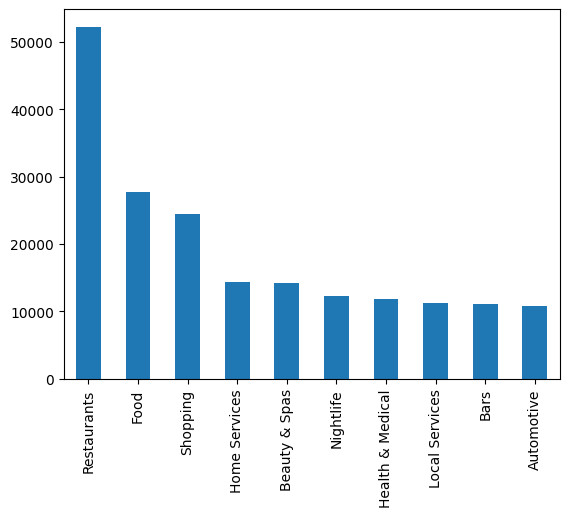

In [ ]:
cats.value_counts().nlargest(10).plot(kind="bar")

In [ ]:
catmap={}
catsset=set(cats.value_counts().nlargest(10).keys().tolist()+["other"])
for row in trans_yelp_business.itertuples(name="Business"):
  bid = row[1]
  catlist = row[8]
  diff = set(catlist)-catsset
  inters = catsset.intersection(catlist)
  if len(diff)>0: 
    inters.union(["other"])
  catmap[bid]=list(inters)

trans_yelp_business['categories']= trans_yelp_business["business_id"].map(catmap)

In [ ]:
encoder1 = MultiLabelBinarizer()
encoder2 = MultiLabelBinarizer()

encoder2.fit(trans_yelp_business["categories"])
encoder1.fit(trans_yelp_business["attributes"])

MultiLabelBinarizer()

In [ ]:
trans_yelp_business = pd.concat([trans_yelp_business,
    pd.DataFrame(encoder2.transform(trans_yelp_business["categories"]), columns=[ f"category_{cla}" for cla in encoder2.classes_ ]),
           pd.DataFrame(encoder1.transform(trans_yelp_business["attributes"]), columns=[ f"attribute_{cla}" for cla in encoder1.classes_ ])],axis=1)

In [ ]:
trans_yelp_business.drop(["categories","attributes"],inplace=True,axis=1)
trans_yelp_business.head(3)

,business_id,name,latitude,longitude,stars,review_count,open_Monday,open_Tuesday,open_Wednesday,open_Thursday,...,attribute_HasTV,attribute_Open24Hours,attribute_OutdoorSeating,attribute_RestaurantsCounterService,attribute_RestaurantsDelivery,attribute_RestaurantsGoodForGroups,attribute_RestaurantsReservations,attribute_RestaurantsTableService,attribute_RestaurantsTakeOut,attribute_WheelchairAccessible
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",34.426679,-119.711197,5.0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,38.551126,-90.335695,3.0,15,0,800,800,800,...,0,0,0,0,0,0,0,0,0,0
2,tUFrWirKiKi_TAnsVWINQQ,Target,32.223236,-110.880452,3.5,22,800,800,800,800,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
trans_yelp_business[trans_yelp_business.isna().any(axis=1)]
# ya no hay nulos y los datos aún conservan el sentido

,business_id,name,latitude,longitude,stars,review_count,open_Monday,open_Tuesday,open_Wednesday,open_Thursday,...,attribute_HasTV,attribute_Open24Hours,attribute_OutdoorSeating,attribute_RestaurantsCounterService,attribute_RestaurantsDelivery,attribute_RestaurantsGoodForGroups,attribute_RestaurantsReservations,attribute_RestaurantsTableService,attribute_RestaurantsTakeOut,attribute_WheelchairAccessible


In [ ]:
joblib.dump(trans_yelp_business,Path(yelp_processed_data,"yelp_academic_dataset_business.joblib"))

['processed_data\\yelp_academic_dataset_business.joblib']

In [ ]:
trans_yelp_business.to_json(Path(yelp_processed_data,"yelp_academic_dataset_business_processed.json"),orient="records",date_format="iso")

### Tip

In [ ]:
yelp_tip_data = reload_dframe(yelp_tip)

In [ ]:
yelp_tip_data.head(3)

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0


In [ ]:
yelp_tip_data.describe()

,compliment_count
count,908915.000000
mean,0.012525
std,0.120763
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,6.000000


No se usará para recomendar, pero se usará como complemento para los negocios que se le recomienden a un usuario. por lo que no se hará ninguna transformación

 - Esto guarda un json listo para cargar a mongo,  lo único que cambia es volvelo una lista válida de jsons

In [ ]:
joblib.dump(yelp_tip_data,Path(yelp_processed_data,"yelp_academic_dataset_tip.joblib"))
yelp_tip_data.to_json(yelp_processed_data/"yelp_academic_dataset_tip_processed.json",orient="records",date_format="iso")

### Checkin

In [ ]:
yelp_checkin_data = reload_dframe(yelp_checkin)

In [ ]:
yelp_checkin_data.head(3)

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"


La idea es usar esto para ver la cantidad de personas en promedio en cada día de la semana.

In [ ]:
%%time
yelp_checkin_data["date"]=yelp_checkin_data["date"].str.split(",")
yelp_checkin_data["checkin_count"]=yelp_checkin_data["date"].apply(len)
yelp_checkin_data.head(3)

CPU times: total: 1.09 s
Wall time: 1.23 s


,business_id,date,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,"[2020-03-13 21:10:56, 2020-06-02 22:18:06, 2...",11
1,--0iUa4sNDFiZFrAdIWhZQ,"[2010-09-13 21:43:09, 2011-05-04 23:08:15, 2...",10
2,--30_8IhuyMHbSOcNWd6DQ,"[2013-06-14 23:29:17, 2014-08-13 23:20:22]",2


In [ ]:
yelp_checkin_data.shape

(131930, 3)

In [ ]:
%%time
yelp_checkin_data["date"] = yelp_checkin_data['date'].apply(pd.to_datetime)
yelp_checkin_data.head(3)

CPU times: total: 26.2 s
Wall time: 30.2 s


,business_id,date,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,"DatetimeIndex(['2020-03-13 21:10:56', '2020-06...",11
1,--0iUa4sNDFiZFrAdIWhZQ,"DatetimeIndex(['2010-09-13 21:43:09', '2011-05...",10
2,--30_8IhuyMHbSOcNWd6DQ,"DatetimeIndex(['2013-06-14 23:29:17', '2014-08...",2


In [ ]:
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [ ]:
minvec = np.vectorize(lambda x: min(x))
maxvec = np.vectorize(lambda x: max(x))
minweekve = np.vectorize(lambda x: min(x.isocalendar().week))
maxweekve = np.vectorize(lambda x: max(x.isocalendar().week))
minyear=min(minvec(yelp_checkin_data["date"])).year
maxyear=max(maxvec(yelp_checkin_data["date"])).year
minweek=min(minweekve(yelp_checkin_data["date"]))
maxweek=max(maxweekve(yelp_checkin_data["date"]))
minyear,maxyear,minweek,maxweek

(2009, 2022, 1, 53)

In [ ]:
totaldistinctdates = ((maxyear+1)-minyear)*((maxweek+1)-minweek)
totaldistinctdates

742

In [ ]:
%%time
# datesmap={bid:{'Monday': {},'Tuesday': {},'Wednesday': {},'Thursday': {},'Friday': {},'Saturday': {},'Sunday': {}} for bid in yelp_checkin_data["business_id"]}
datesmap={day:{bid:{} for bid in yelp_checkin_data["business_id"]} for day in days}
for row in yelp_checkin_data.itertuples(name="Checkin"):
  bid = row[1]
  checkins = row[2]
  for cki in checkins:
    week,dayname=cki.isocalendar().week,cki.day_name()
    if week in datesmap[dayname][bid]:
      datesmap[dayname][bid][week]+=1
    else:
      datesmap[dayname][bid][week]=1
  for day in days:
    totaldaycheckins=sum(datesmap[day][bid].values())
    datesmap[day][bid]=totaldaycheckins/totaldistinctdates

CPU times: total: 49 s
Wall time: 53.5 s


In [ ]:
datesmap["Monday"]["-QI8Qi8XWH3D8y8ethnajA"] # 11.71

11.715633423180593

In [ ]:
for day,bidobj in datesmap.items():
  yelp_checkin_data[f"avg_{day}"] = yelp_checkin_data["business_id"].map(bidobj)


In [ ]:

yelp_checkin_data.drop(["date"],axis=1,inplace=True)

Al final se tiene el conteo de visitas promedio por día de la semana

In [ ]:
yelp_checkin_data.nlargest(columns="avg_Monday",n=3)

,business_id,checkin_count,avg_Monday,avg_Tuesday,avg_Wednesday,avg_Thursday,avg_Friday,avg_Saturday,avg_Sunday
878,-QI8Qi8XWH3D8y8ethnajA,52144,11.715633,9.324798,9.110512,10.346361,11.393531,8.661725,9.722372
83440,c_4c5rJECZSfNgFj7frwHQ,37518,8.799191,6.470350,6.473046,7.588949,8.241240,6.156334,6.834232
32401,Eb1XmmLWyt_way5NNZ7-Pw,37562,8.192722,6.274933,6.431267,7.650943,8.066038,6.929919,7.076819


In [ ]:
joblib.dump(yelp_checkin_data,Path(yelp_processed_data,"yelp_academic_dataset_checkin.joblib"))
yelp_checkin_data.to_json(yelp_processed_data/"yelp_academic_dataset_checkin_processed.json",orient="records",date_format="iso")

### User

In [ ]:
%%time
yelp_user_data = reload_dframe(yelp_user)

CPU times: total: 1.55 s
Wall time: 12.6 s


In [ ]:
yelp_user_data.head(3)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18


In [ ]:
len(yelp_user_data.index)

1987897

In [ ]:
yelp_user_data.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06
mean,2.339441e+01,4.229634e+01,1.697054e+01,2.379291e+01,1.465740e+00,3.630494e+00,1.807072e+00,2.922631e-01,1.793176e-01,1.336493e-01,6.390723e-02,1.443135e+00,3.011841e+00,2.829308e+00,2.829308e+00,1.056448e+00,1.226859e+00
std,8.256699e+01,6.414806e+02,4.078034e+02,5.653513e+02,1.813075e+01,1.183337e+00,7.360184e+01,1.282467e+01,1.515525e+01,1.135682e+01,1.004363e+01,6.016790e+01,1.193898e+02,9.666385e+01,9.666385e+01,3.217973e+01,9.515751e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.880000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.700000e+01,1.300000e+01,2.000000e+00,3.000000e+00,0.000000e+00,4.560000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.747300e+04,2.062960e+05,1.858230e+05,1.998780e+05,1.249700e+04,5.000000e+00,2.578400e+04,1.350100e+04,1.418000e+04,1.365400e+04,1.266900e+04,5.903100e+04,1.010970e+05,4.996700e+04,4.996700e+04,1.593400e+04,8.263000e+04


In [ ]:
yelp_user_data.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')


 - Se elimina el Name porque no aporta información útil
 

In [ ]:
processed_yelp_user_data = yelp_user_data.drop(columns=["name"])
processed_yelp_user_data.head(3)

,user_id,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,3.32,...,13,10,17,3,66,96,119,119,35,18



 - "yelping_since" se cambia de la fecha de registro a "days_yelping", que corresponde a los días que el usuario lleva registrado en la plataforma (luego, un usuario más antiguo tiene más peso/credibilidad)

In [ ]:
today = datetime.datetime.now()
calculate=np.vectorize(lambda x: (today - pd.to_datetime(x)).days)
processed_yelp_user_data["days_yelping"]= calculate(yelp_user_data["yelping_since"])
processed_yelp_user_data.drop(columns=["yelping_since"],inplace=True)
processed_yelp_user_data.head(3)

,user_id,review_count,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,days_yelping
0,qVc8ODYU5SZjKXVBgXdI7w,585,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,...,55,56,18,232,844,467,467,239,180,5948
1,j14WgRoU_-2ZE1aw1dXrJg,4333,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,1145,...,184,157,251,1847,7054,3131,3131,1521,1946,5218
2,2WnXYQFK0hXEoTxPtV2zvg,665,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,3.32,89,...,10,17,3,66,96,119,119,35,18,5401



 - se elimina Friends porque no se me ocurre nada útil para hacer con esos ids

In [ ]:
processed_yelp_user_data.drop(columns=["friends"],inplace=True)
processed_yelp_user_data.head(3)

,user_id,review_count,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,days_yelping
0,qVc8ODYU5SZjKXVBgXdI7w,585,7217,1259,5994,2007,267,3.91,250,65,55,56,18,232,844,467,467,239,180,5948
1,j14WgRoU_-2ZE1aw1dXrJg,4333,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946,5218
2,2WnXYQFK0hXEoTxPtV2zvg,665,2086,1010,1003,"2009,2010,2011,2012,2013",52,3.32,89,13,10,17,3,66,96,119,119,35,18,5401



 - se combinan useful, funny y cool (sumando) en un único valor "votes" para ser consistente con el resto de archivos/datos

In [ ]:
processed_yelp_user_data["votes"] = yelp_user_data["useful"]+yelp_user_data["funny"]+yelp_user_data["cool"]
processed_yelp_user_data.drop(columns=["useful","funny","cool"],inplace=True)
processed_yelp_user_data.head(3)

,user_id,review_count,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,days_yelping,votes
0,qVc8ODYU5SZjKXVBgXdI7w,585,2007,267,3.91,250,65,55,56,18,232,844,467,467,239,180,5948,14470
1,j14WgRoU_-2ZE1aw1dXrJg,4333,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946,5218,83438
2,2WnXYQFK0hXEoTxPtV2zvg,665,"2009,2010,2011,2012,2013",52,3.32,89,13,10,17,3,66,96,119,119,35,18,5401,4099



 - elite se divide en "times_elite" que indica cuántos años distintos el usuario ha sido elite, y "latest_elite" que indica el año más reciente en el que el usuario fue elite. (luego, más años élite y más reciente = usuario más relevante)

In [ ]:
processed_yelp_user_data["times_elite"] = yelp_user_data["elite"].str.split(",").apply(len)
processed_yelp_user_data["latest_elite"] = yelp_user_data["elite"].str.split(",").apply(max)
processed_yelp_user_data.drop(columns=["elite"],inplace=True)
processed_yelp_user_data.head(3)

,user_id,review_count,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,days_yelping,votes,times_elite,latest_elite
0,qVc8ODYU5SZjKXVBgXdI7w,585,267,3.91,250,65,55,56,18,232,844,467,467,239,180,5948,14470,1,2007
1,j14WgRoU_-2ZE1aw1dXrJg,4333,3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946,5218,83438,14,2021
2,2WnXYQFK0hXEoTxPtV2zvg,665,52,3.32,89,13,10,17,3,66,96,119,119,35,18,5401,4099,5,2013



 - Se combinan los compliment_x (sumando) en un único valor "compliments" porque parecen muy similares, los datasets anteriores parecen también enforcarse en "compliments" sin segregar el tipo

In [ ]:
compliment_columns=["compliment_hot",
                    "compliment_more",
                    "compliment_profile",
                    "compliment_cute",
                    "compliment_list",
                    "compliment_note",
                    "compliment_plain",
                    "compliment_cool",
                    "compliment_funny",
                    "compliment_writer",
                    "compliment_photos"]
processed_yelp_user_data["compliments"] = yelp_user_data[compliment_columns].sum(axis=1)
processed_yelp_user_data.drop(columns=compliment_columns,inplace=True)
processed_yelp_user_data.head(3)

,user_id,review_count,fans,average_stars,days_yelping,votes,times_elite,latest_elite,compliments
0,qVc8ODYU5SZjKXVBgXdI7w,585,267,3.91,5948,14470,1,2007,2873
1,j14WgRoU_-2ZE1aw1dXrJg,4333,3138,3.74,5218,83438,14,2021,20631
2,2WnXYQFK0hXEoTxPtV2zvg,665,52,3.32,5401,4099,5,2013,585


In [ ]:
joblib.dump(yelp_user_data,Path(yelp_processed_data,"yelp_academic_dataset_user.joblib"))
yelp_user_data.to_json(yelp_processed_data/"yelp_academic_dataset_user_processed.json",orient="records",date_format="iso")

### Review

Estos sí son "los datos de entrenamiento", en el sentido de que aquí está el objetivo (stars), de modo que se hace un split train/test 

In [ ]:
%%time
yelp_review_data = reload_dframe(yelp_review)
cols = list(yelp_review_data.columns)
cols.remove("stars")


CPU times: total: 5.36 s
Wall time: 26.9 s


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(yelp_review_data[cols], yelp_review_data["stars"], test_size=0.2, random_state=4201)


In [ ]:
len(x_train.index)

5592224

In [ ]:
len(x_test.index)

1398056

In [ ]:
x_train.head(3)

,review_id,user_id,business_id,useful,funny,cool,text,date
604436,4aunfqzB6ePUrrUE-6wiMw,3pgH-8ivpeLT9ODFWyF9dg,uzeB4Y0eOwjt7Yjsx6tc5A,12,0,0,Make sure you get a FIRM QUOTE ahead of time i...,2014-07-21 22:20:42
1760546,0KiAZiXW47m8GWBzjRZgNg,DinbFoJU9UPNNqy0_KcHvA,qK85LZ9wOJBETnmE1jsxEg,0,0,0,I have been seeing Edmy for about 6 months now...,2017-12-28 18:23:27
3327980,GSYpA_edgA80jKadRw8FvA,mvK1pv-x0Z5rP4Hz9cWBWw,qclZoDz3sjT7v5xOSj5P2Q,24,14,21,**DON'T ORDER A FANCY COCKTAIL AND YOU'LL BE F...,2014-07-30 16:09:25


In [ ]:
x_train["business_id"].nunique()

150344

In [ ]:
x_train["user_id"].nunique()

1746388

#### Preprocesamiento no textual

Aquí sí vale la pena eliminar el review_id

In [ ]:
def step1(dframe):
  df_copy = dframe.drop(columns=["review_id"])
  return df_copy
x_train= step1(x_train)
x_train.head(3)

,user_id,business_id,useful,funny,cool,text,date
604436,3pgH-8ivpeLT9ODFWyF9dg,uzeB4Y0eOwjt7Yjsx6tc5A,12,0,0,Make sure you get a FIRM QUOTE ahead of time i...,2014-07-21 22:20:42
1760546,DinbFoJU9UPNNqy0_KcHvA,qK85LZ9wOJBETnmE1jsxEg,0,0,0,I have been seeing Edmy for about 6 months now...,2017-12-28 18:23:27
3327980,mvK1pv-x0Z5rP4Hz9cWBWw,qclZoDz3sjT7v5xOSj5P2Q,24,14,21,**DON'T ORDER A FANCY COCKTAIL AND YOU'LL BE F...,2014-07-30 16:09:25


 - Se combinan sumando "useful", "funny" y "cool" para mantener la consistencia con "compliments" y "votes"
 

In [ ]:
%%time
def step2(dframe):
  df_copy = dframe.copy()
  df_copy["votes"] = df_copy[["useful","funny","cool"]].sum(axis=1)
  df_copy.drop(columns=["useful","funny","cool"],inplace=True)
  return df_copy

x_train= step2(x_train)
x_train.head(3)

CPU times: total: 719 ms
Wall time: 972 ms


,user_id,business_id,text,date,votes
604436,3pgH-8ivpeLT9ODFWyF9dg,uzeB4Y0eOwjt7Yjsx6tc5A,Make sure you get a FIRM QUOTE ahead of time i...,2014-07-21 22:20:42,12
1760546,DinbFoJU9UPNNqy0_KcHvA,qK85LZ9wOJBETnmE1jsxEg,I have been seeing Edmy for about 6 months now...,2017-12-28 18:23:27,0
3327980,mvK1pv-x0Z5rP4Hz9cWBWw,qclZoDz3sjT7v5xOSj5P2Q,**DON'T ORDER A FANCY COCKTAIL AND YOU'LL BE F...,2014-07-30 16:09:25,59



 - Se cambia "date" por "days_since_review" para darle mayor valor a las reviews más recientes

In [ ]:
%%time
today = datetime.datetime.now()
calculate=np.vectorize(lambda x: (today - pd.to_datetime(x)).days)

def step3(dframe):
  df_copy = dframe.copy()#operation
  df_copy["days_since_review"] = calculate(df_copy["date"])
  df_copy.drop(columns=["date"],inplace=True)
  return df_copy

x_train= step3(x_train)
x_train.head(3)

CPU times: total: 26.3 s
Wall time: 30.1 s


,user_id,business_id,text,votes,days_since_review
604436,3pgH-8ivpeLT9ODFWyF9dg,uzeB4Y0eOwjt7Yjsx6tc5A,Make sure you get a FIRM QUOTE ahead of time i...,12,3214
1760546,DinbFoJU9UPNNqy0_KcHvA,qK85LZ9wOJBETnmE1jsxEg,I have been seeing Edmy for about 6 months now...,0,1959
3327980,mvK1pv-x0Z5rP4Hz9cWBWw,qclZoDz3sjT7v5xOSj5P2Q,**DON'T ORDER A FANCY COCKTAIL AND YOU'LL BE F...,59,3206


In [ ]:
joblib.dump(x_train, Path(yelp_processed_data,"yelp_train.joblib"))

['processed_data\\yelp_train.joblib']

In [ ]:
%%time
trans_x_test=step3(step2(step1(x_test)))

CPU times: total: 4.8 s
Wall time: 8.4 s


In [ ]:
x_train=joblib.load(Path(yelp_processed_data,"yelp_train.joblib"))

#### Preprocesamiento de texto

In [ ]:
x_train.head(3)

,user_id,business_id,text,votes,days_since_review
604436,3pgH-8ivpeLT9ODFWyF9dg,uzeB4Y0eOwjt7Yjsx6tc5A,Make sure you get a FIRM QUOTE ahead of time i...,12,3214
1760546,DinbFoJU9UPNNqy0_KcHvA,qK85LZ9wOJBETnmE1jsxEg,I have been seeing Edmy for about 6 months now...,0,1959
3327980,mvK1pv-x0Z5rP4Hz9cWBWw,qclZoDz3sjT7v5xOSj5P2Q,**DON'T ORDER A FANCY COCKTAIL AND YOU'LL BE F...,59,3206


In [ ]:
def text_preprocessing_stemming(text,lang="english",stop_words=stopwords.words("english"),
                                translation=str.maketrans('','',string.punctuation),
                                stemmer=EnglishStemmer(),lemmatizer=WordNetLemmatizer(),
                                inflecteng=inflect.engine()):
  # esto solo es un resumen de la funcion preprocessing(words)
  # 1. normalizar, 2. lowercase, 3. remover puntuación, 4. tokenizar, 5. remover stopwords, 6. Lematizar, 7. Stemming
  # se tokeniza al final porque es equivalente y más rápido
  return list(
      map(stemmer.stem,
          map(lemmatizer.lemmatize,
              #map(lambda word: inflecteng.number_to_words(word) if word.isdigit() else word, # crashea
              filter(lambda x: 
                    x not in stop_words,
                    word_tokenize(ud.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8").lower().translate(translation),language=lang)
                    )
               #   )
              )
          )
      )

def dframe_preprocessing_stemming(dframe,lang="english"):
  # esto asume que no se ha preprocesado nada
  dcopy=dframe.copy()
  stop_words = stopwords.words(lang)
  translation=str.maketrans('','',string.punctuation)
  stemmer=EnglishStemmer() if lang=="english" else SnowballStemmer(lang)
  lemmatizer=WordNetLemmatizer()
  inflecteng=inflect.engine()
  dcopy["text"]=dcopy["text"].apply(text_preprocessing_stemming,stop_words=stop_words,translation=translation,stemmer=stemmer,lemmatizer=lemmatizer,inflecteng=inflecteng)
  return dcopy

In [ ]:
dummy_func = lambda x: x
tfidf = TfidfVectorizer(lowercase=False,preprocessor=dummy_func,tokenizer=dummy_func)

In [ ]:
6990280//512

13652

In [ ]:
%%time
tstart_total = perf_counter_ns()
nrows = len(yelp_review_data.index) # todas
n_jobs=512
chunk_size = nrows // n_jobs  # el chunk size
chunks = [yelp_review_data[i:i+chunk_size] for i in range(0, nrows, chunk_size)]
processed_chunks=[]
print(f"{nrows=}, {len(chunks)=}")
for indx,piece in enumerate(chunks):
  tstart_ch = perf_counter_ns()
  processed_chunks.append(dframe_preprocessing_stemming(piece,"english"))
  totaltime_ch= perf_counter_ns()-tstart_ch
  tot_ch_s = totaltime_ch/1e9
  print(f"chunks done: {indx} of {len(chunks)} | current speed: {chunk_size/(tot_ch_s):.3f} rows/s")
yelp_review_data_text_processed = pd.concat(processed_chunks) 
totaltime_total= perf_counter_ns()-tstart_total
tot_ms = totaltime_total/1e6
print(f"total time taken for {nrows} rows: {tot_ms:.3f} ms | {nrows/tot_ms:.3f} rows/ms -> {nrows/(tot_ms/1e3):.3f} rows/s")

yelp_review_data_text_processed.head(3)

In [ ]:
cols = list(yelp_review_data_text_processed.columns)
cols.remove("text")
cols

['review_id', 'user_id', 'business_id', 'stars', 'votes', 'days_since_review']

In [ ]:
text_rows = pd.DataFrame.sparse.from_spmatrix(tfidf.fit_transform(yelp_review_data_text_processed["text"]),columns=tfidf.get_feature_names_out())
tfidfmatrix = pd.concat([yelp_review_data_text_processed[cols],text_rows],axis=1)
tfidfmatrix.head(3)

C:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,review_id,user_id,business_id,stars,votes,days_since_review,0,000,01,050,...,zax,zaxbi,zeller,zeppol,zero,zest,ziggi,zone,zucchini,zurich
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,1767,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,2,4144,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,3380,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidfmatrix.shape

In [ ]:
joblib.dump(tfidfmatrix, Path(yelp_processed_data,"yelp_academic_dataset_review_tf_idf_matrix.joblib"))

In [ ]:
#mrr

def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [ ]:
# Se establece el rango en el cual se aceptaran los ratings
reader = Reader( rating_scale = ( 1, 5 ) )

## 2. Transformación de los dataset al formato de Surprise

In [ ]:
# Assuming df is your DataFrame and it has columns 'user_id', 'business_id' and 'stars'
df_train, df_temp = train_test_split(yelp_review_data, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [ ]:
df_train.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
4763105,5xbDIl2IahpTufrr4M7M9A,V_46L2RMM2GrSorJMpOCkw,OJEiB_a2I_gxC-ZeayI94A,3,0,0,0,Visited the Another Broken Egg Cafe yesterday....,2019-03-20 14:59:49
3276572,r1bQOym6LOTHWZB3zd6Y0w,JGeVD5-0bKKnXnZxaTZUZQ,bRTWD05drzNfzVP0IadX7A,1,0,0,0,"I typically don't write reviews, but this plac...",2015-05-22 23:06:23
3769481,U23V0kEAYQ9QeuBpNqc0QA,VRKuCyuCYZGzCpMankWH1Q,232qg1k9QV0pNt90jyTatA,4,0,0,0,One of my goals for my New Orleans trip was to...,2017-11-17 10:23:07
1362927,Kk_TReiaS3CgIk_YoeZ5KQ,ohQzhkPJtKUmdAhHP6xZdw,Y5RUhntIPDfe2eKriQFIZg,5,0,0,0,Went here for the first time last night for dr...,2016-11-21 16:00:13
6976103,He83DqAVvvRgTM4JddlleQ,HVQKFDi-vZbawtmLMq3ZOw,0RuvlgTnKFbX3IK0ZOOocA,5,1,0,0,Green eggs cafe was amazing! My boyfriend and ...,2020-07-20 18:46:14


In [ ]:
# The columns must correspond to user id, item id and ratings (in that order).
data_train = Dataset.load_from_df(df_train[['user_id', 'business_id', 'stars']], reader)
data_val = Dataset.load_from_df(df_val[['user_id', 'business_id', 'stars']], reader)
data_test = Dataset.load_from_df(df_test[['user_id', 'business_id', 'stars']], reader)

In [ ]:
# Surprise requiere que explicitamente los datasets sean transformados a datasets de entrenamiento y prueba en cada caso 
# Si bien no se entrenará sobre los datasets de validación y prueba, surprise requiere que sean tranformados a entrenamiento para posteriormente ser transformados a prueba
train_data = data_train.build_full_trainset()
validation_data = data_val.build_full_trainset()
test_data = data_test.build_full_trainset()

In [ ]:
# Finalmente, se convierten los 3 datasets a prueba ya que se medirá el error obtenido en los 3
train_data_2 = train_data.build_testset()
validation_data = validation_data.build_testset()
test_data = test_data.build_testset()

## 3. Entrenamiento de un modelo SVD con bias

In [ ]:
mean = train_data.global_mean
print( mean )

3.7485801713236095


In [ ]:
gs_params = {
    # cambiar las k dimensiones
    "n_factors":list(range(35,45)),
    "reg_all":[0,0.01,1],
    "biased":[True],
    "lr_all":[0.01,0.1,0.5]
    }

svd = SVD( n_epochs = 200,init_mean = 0, init_std_dev = 0.01 )

gs_large = GridSearchCV(SVD, gs_params, measures=["rmse","mae"], cv=3,n_jobs=-1,return_train_measures=True,joblib_verbose=2)

In [ ]:
%%time
gs_large.fit(data_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 67.4min


CPU times: user 1h 35min 35s, sys: 6min 6s, total: 1h 41min 42s
Wall time: 2h 8min 35s


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 126.1min finished


In [ ]:
gs_large.best_params

{'rmse': {'n_factors': 36, 'reg_all': 0.01, 'biased': True, 'lr_all': 0.01},
 'mae': {'n_factors': 35, 'reg_all': 0.01, 'biased': True, 'lr_all': 0.01}}

In [ ]:
gs_large.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f333c6b1c90>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f333c6b0ca0>}

In [ ]:
best_model = gs_large.best_estimator['rmse']
best_model

In [ ]:
# Save the trained model
pickle.dump(best_model, open('/content/drive/MyDrive/Colab Notebooks/Data/model.pkl', 'wb'))

In [ ]:
trainset = data_train.build_full_trainset()
best_model.fit(trainset)

In [ ]:
# Get predictions for validation and test sets
predictions_validation = best_model.test(validation_data)
predictions_test = best_model.test(test_data)

# Then compute RMSE for both
rmse_validation = accuracy.rmse(predictions_validation)
rmse_test = accuracy.rmse(predictions_test)

print(f'Validation RMSE: {rmse_validation}')
print(f'Test RMSE: {rmse_test}')

RMSE: 1.3081
RMSE: 1.3082
Validation RMSE: 1.3081218201996487
Test RMSE: 1.308223600016433


In [ ]:
def get_all_predictions(user_id):
    # Get a list of all item ids
    iids = yelp_review_data['business_id'].unique()

    # Get a list of ids that the user has rated
    iids_user_rated = yelp_review_data.loc[yelp_review_data['user_id'] == user_id, 'business_id']

    # Remove the ids that the user has rated from the list of all item ids
    iids_to_pred = np.setdiff1d(iids, iids_user_rated)

    # Predict the rating for all items that the user hasn't rated yet
    predictions = [best_model.predict(user_id, iid) for iid in iids_to_pred]

    # return predictions in form of dataframe
    return pd.DataFrame(predictions)

In [ ]:
# Get all predictions for specific user
user_id = 'qVc8ODYU5SZjKXVBgXdI7w'  # replace with the user id you're interested in
all_predictions = get_all_predictions(user_id)

# Order the predictions from highest to lowest rated
ranked_predictions = all_predictions.sort_values(by='est', ascending=False)

# Print out the recommended items for the user
print(ranked_predictions)

                           uid                     iid  r_ui       est  \
52560   qVc8ODYU5SZjKXVBgXdI7w  LNv9jNMMU7-i-NxcLM5A3A  None  5.000000   
78476   qVc8ODYU5SZjKXVBgXdI7w  WTJrTbMgLHFwU8HPRFA7_Q  None  5.000000   
78462   qVc8ODYU5SZjKXVBgXdI7w  WStVCYmGWYtn1AZ_SvEDtQ  None  5.000000   
123671  qVc8ODYU5SZjKXVBgXdI7w  oklaxORZG7V0beWhEN_N8w  None  5.000000   
97073   qVc8ODYU5SZjKXVBgXdI7w  dRqRBDrQZsNKo72JlEcejw  None  5.000000   
...                        ...                     ...   ...       ...   
90388   qVc8ODYU5SZjKXVBgXdI7w  a_OkPbk51U7gCyArNEna0g  None  1.062890   
53637   qVc8ODYU5SZjKXVBgXdI7w  LreM6Gs1JUh3bY1hVhy7VA  None  1.028825   
109760  qVc8ODYU5SZjKXVBgXdI7w  io4YNLvABJrFraEwtQBWqA  None  1.015807   
106928  qVc8ODYU5SZjKXVBgXdI7w  hb4Viui0dPDUpFqN1PbRKA  None  1.000000   
104392  qVc8ODYU5SZjKXVBgXdI7w  gY4kIh8f9uCk-XI0FPH1fg  None  1.000000   

                          details  
52560   {'was_impossible': False}  
78476   {'was_impossible': False}  
784

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def get_top_n_similar(n, item_id, item_factors):
    # Fit nearest neighbors
    knn = NearestNeighbors(n_neighbors=n+1)  # +1 because the item is most similar to itself
    knn.fit(item_factors)
    
    # Get neighbors indices
    distances, indices = knn.kneighbors(item_factors[item_id].reshape(1, -1))
    
    # Exclude the item itself
    return indices[0][1:]

def get_top_n_similar_users(n, user_id, user_factors):
    # Fit nearest neighbors
    knn = NearestNeighbors(n_neighbors=n+1)  # +1 because the user is most similar to himself/herself
    knn.fit(user_factors)
    
    # Get neighbors indices
    distances, indices = knn.kneighbors(user_factors[user_id].reshape(1, -1))
    
    # Exclude the user itself
    return indices[0][1:]

In [ ]:
# Assume best_model is your trained SVD model
item_factors = best_model.qi
user_factors = best_model.pu

user_id = train_data.to_inner_uid('mh_-eMZ6K5RLWhZyISBhwA')

item_id = train_data.to_inner_iid('OJEiB_a2I_gxC-ZeayI94A')

# Get top 5 similar items for item with ID 10
similar_items = get_top_n_similar(5, 10, item_factors)
# Transform inner item IDs to raw item IDs
similar_items_raw = [train_data.to_raw_iid(i) for i in similar_items]
print(f"Top 5 similar items for item {train_data.to_raw_iid(item_id)}: {similar_items_raw}")

# Get top 5 similar users for user with ID 20
similar_users = get_top_n_similar_users(5, user_id, user_factors)
# Transform inner user IDs to raw user IDs
similar_users_raw = [train_data.to_raw_uid(i) for i in similar_users]
print(f"Top 5 similar users for user {train_data.to_raw_uid(user_id)}: {similar_users_raw}")

Top 5 similar items for item OJEiB_a2I_gxC-ZeayI94A: ['q4sI8dkd3QaGQ4qY-GQa2A', 'xDgIMuNfUrm72YZlBesUgg', 'r17TZ4H2vyptAV3nuydGsw', 'Ga2GyMUjrN7V0vhJVA-wBA', '0KEt5T4AlzHhGJXrgrJ1Ww']
Top 5 similar users for user mh_-eMZ6K5RLWhZyISBhwA: ['MCiWSAJcBHrXVFVslZqoTw', 'i4BA2SfIgj4CL7fJSefwqA', 'YXiERKhX7h5p2dBU24dcxg', '10ks1QgTTU9dfm8e2yt2vw', 'UwdN2diFAczEbSQXE7l4EQ']


In [ ]:
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [ ]:
# Get predictions for validation and test sets
predictions_validation = best_model.test(validation_data)
predictions_test = best_model.test(test_data)

# Convert the predictions to lists of predicted business IDs
predicted_validation = [pred.iid for pred in predictions_validation]
predicted_test = [pred.iid for pred in predictions_test]

# Extract the actual business IDs from the validation and test sets
y_validation = [row[1] for row in validation_data]
y_test = [row[1] for row in test_data]

# Calculate the MRR for both
mrr_validation = mean_reciprocal_rank(y_validation, predicted_validation)
mrr_test = mean_reciprocal_rank(y_test, predicted_test)

print(f'Validation MRR: {mrr_validation}')
print(f'Test MRR: {mrr_test}')